## **Objective**  
In this episode we are given the task of predicting the rainfall for each day of the year. 
Submissions are evaluated on the **Area Under the Receiver Operating Characteristic Curve** between the predicted probability and the observed target.

**AUC-ROC** is defined as:

$$
\textrm{AUC} = \sum_{i=1}^{n} ( \textrm{FPR}_i - \textrm{FPR}_{i-1} ) \times \textrm{TPR}_i
$$
 
## **Data Overview**  
The dataset for this competition is generated from a deep learning model trained on the [Rainfall Prediction using Machine Learning](https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning)  

**Key Features:**  
- **Pressure:** Atmospheric pressure recorded daily.  
- **Max Temperature (maxtemp):** Highest temperature recorded in a day.  
- **Temperature:** Average daily temperature.  
- **Min Temperature (mintemp):** Lowest temperature recorded in a day.  
- **Dew Point:** Temperature at which condensation occurs.  
- **Humidity:** Percentage of moisture in the air.  
- **Cloud Cover:** Extent of cloudiness during the day.  
- **Sunshine Duration:** Total hours of sunshine received in a day.  
- **Wind Direction:** Direction from which the wind is blowing.  
- **Wind Speed:** Speed of the wind measured in a given unit.  
- **Day:** Recorded day of the year.  

In [1]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
#from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid", palette="muted")

print('Libaires imported')

Libaires imported


In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

print('Data imported')

Data imported


In [3]:
print("Train Data Preview:")
display(train_data.tail())

print("\nTest Data Preview:")
display(test_data.head())

Train Data Preview:


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
2185  2185  361    1014.6     23.2         20.6     19.1      19.9      97.0   
2186  2186  362    1012.4     17.2         17.3     16.3      15.3      91.0   
2187  2187  363    1013.3     19.0         16.3     14.3      12.6      79.0   
2188  2188  364    1022.3     16.4         15.2     13.8      14.7      92.0   
2189  2189  365    1013.8     21.2         19.1     18.0      18.0      89.0   

      cloud  sunshine  winddirection  windspeed  rainfall  
2185   88.0       0.1           40.0       22.1         1  
2186   88.0       0.0           50.0       35.3         1  
2187   79.0       5.0           40.0       32.9         1  
2188   93.0       0.1           40.0       18.0         1  
2189   88.0       1.0           70.0       48.0         1


Test Data Preview:


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0  2190    1    1019.5     17.5         15.8     12.7      14.9      96.0   
1  2191    2    1016.5     17.5         16.5     15.8      15.1      97.0   
2  2192    3    1023.9     11.2         10.4      9.4       8.9      86.0   
3  2193    4    1022.9     20.6         17.3     15.2       9.5      75.0   
4  2194    5    1022.2     16.1         13.8      6.4       4.3      68.0   

   cloud  sunshine  winddirection  windspeed  
0   99.0       0.0           50.0       24.3  
1   99.0       0.0           50.0       35.3  
2   96.0       0.0           40.0       16.9  
3   45.0       7.1           20.0       50.6  
4   49.0       9.2           20.0       19.4

In [4]:
# Removing whitespace in column names
train_data.columns = train_data.columns.str.strip()
test_data.coloumns = test_data.columns.str.strip()

# Correct spelling inconsistency in train_data
train_data = train_data.rename(columns={'temparature': 'temperature'})
test_data = test_data.rename(columns={'temparature': 'temperature'})

In [5]:
print("Train Data Preview:")
display(train_data.tail())

print("\nTest Data Preview:")
display(test_data.head())

Train Data Preview:


id  day  pressure  maxtemp  temperature  mintemp  dewpoint  humidity  \
2185  2185  361    1014.6     23.2         20.6     19.1      19.9      97.0   
2186  2186  362    1012.4     17.2         17.3     16.3      15.3      91.0   
2187  2187  363    1013.3     19.0         16.3     14.3      12.6      79.0   
2188  2188  364    1022.3     16.4         15.2     13.8      14.7      92.0   
2189  2189  365    1013.8     21.2         19.1     18.0      18.0      89.0   

      cloud  sunshine  winddirection  windspeed  rainfall  
2185   88.0       0.1           40.0       22.1         1  
2186   88.0       0.0           50.0       35.3         1  
2187   79.0       5.0           40.0       32.9         1  
2188   93.0       0.1           40.0       18.0         1  
2189   88.0       1.0           70.0       48.0         1


Test Data Preview:


id  day  pressure  maxtemp  temperature  mintemp  dewpoint  humidity  \
0  2190    1    1019.5     17.5         15.8     12.7      14.9      96.0   
1  2191    2    1016.5     17.5         16.5     15.8      15.1      97.0   
2  2192    3    1023.9     11.2         10.4      9.4       8.9      86.0   
3  2193    4    1022.9     20.6         17.3     15.2       9.5      75.0   
4  2194    5    1022.2     16.1         13.8      6.4       4.3      68.0   

   cloud  sunshine  winddirection  windspeed  
0   99.0       0.0           50.0       24.3  
1   99.0       0.0           50.0       35.3  
2   96.0       0.0           40.0       16.9  
3   45.0       7.1           20.0       50.6  
4   49.0       9.2           20.0       19.4

In [6]:
train_duplicates = train_data.duplicated().sum()
test_duplicates = test_data.duplicated().sum()

print(f'Number of duplicate rows in train_data: {train_duplicates}')
print(f'Number of duplicate rows in test_data: {test_duplicates}')

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0


In [7]:
#Missing and unique values

missing_values_train = pd.DataFrame({'Feature': train_data.columns,
                                     '[TRAIN] Missing Values': train_data.isnull().sum().values})

missing_values_test = pd.DataFrame({'Feature': test_data.columns,
                                     '[TEST] Missing Values': test_data.isnull().sum().values})

unique_values_train = pd.DataFrame({'Feature': train_data.columns,
                              '[TRAIN] Unique Values': train_data.nunique().values})

unique_values_test = pd.DataFrame({'Feature': test_data.columns,
                              '[TEST] Unique Values': test_data.nunique().values})

feature_types = pd.DataFrame({'Feature': train_data.columns,
                              '[TRAIN] DataType': train_data.dtypes})

merged_df = pd.merge(missing_values_train, missing_values_test, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values_train, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values_test, on='Feature', how='left')
merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

merged_df

Feature  [TRAIN] Missing Values  [TEST] Missing Values  \
0              id                       0                    0.0   
1             day                       0                    0.0   
2        pressure                       0                    0.0   
3         maxtemp                       0                    0.0   
4     temperature                       0                    0.0   
5         mintemp                       0                    0.0   
6        dewpoint                       0                    0.0   
7        humidity                       0                    0.0   
8           cloud                       0                    0.0   
9        sunshine                       0                    0.0   
10  winddirection                       0                    1.0   
11      windspeed                       0                    0.0   
12       rainfall                       0                    NaN   

    [TRAIN] Unique Values  [TEST] Unique Values [TRAIN] DataType  
0                    2190                 730.0            int64  
1                     365                 365.0            int64  
2                     236                 185.0          float64  
3                     219                 182.0          float64  
4                     198                 175.0          float64  
5                     199                 171.0          float64  
6                     218                 172.0          float64  
7                      49                  42.0          float64  
8                      78                  69.0          float64  
9                     120                 110.0          float64  
10                     35                  29.0          float64  
11                    223                 205.0          float64  
12                      2                   NaN            int64

In [8]:
train_data.describe().T

count         mean         std    min       25%      50%  \
id             2190.0  1094.500000  632.342866    0.0   547.250  1094.50   
day            2190.0   179.948402  105.203592    1.0    89.000   178.50   
pressure       2190.0  1013.602146    5.655366  999.0  1008.600  1013.00   
maxtemp        2190.0    26.365799    5.654330   10.4    21.300    27.80   
temperature    2190.0    23.953059    5.222410    7.4    19.300    25.50   
mintemp        2190.0    22.170091    5.059120    4.0    17.700    23.85   
dewpoint       2190.0    20.454566    5.288406   -0.3    16.800    22.15   
humidity       2190.0    82.036530    7.800654   39.0    77.000    82.00   
cloud          2190.0    75.721918   18.026498    2.0    69.000    83.00   
sunshine       2190.0     3.744429    3.626327    0.0     0.400     2.40   
winddirection  2190.0   104.863151   80.002416   10.0    40.000    70.00   
windspeed      2190.0    21.804703    9.898659    4.4    14.125    20.50   
rainfall       2190.0     0.753425    0.431116    0.0     1.000     1.00   

                    75%     max  
id             1641.750  2189.0  
day             270.000   365.0  
pressure       1017.775  1034.6  
maxtemp          31.200    36.0  
temperature      28.400    31.5  
mintemp          26.400    29.8  
dewpoint         25.000    26.7  
humidity         88.000    98.0  
cloud            88.000   100.0  
sunshine          6.800    12.1  
winddirection   200.000   300.0  
windspeed        27.900    59.5  
rainfall          1.000     1.0

In [9]:
test_data.describe().T

count         mean         std     min       25%      50%  \
id             730.0  2554.500000  210.877136  2190.0  2372.250  2554.50   
day            730.0   183.000000  105.438271     1.0    92.000   183.00   
pressure       730.0  1013.503014    5.505871  1000.0  1008.725  1012.70   
maxtemp        730.0    26.372466    5.672521     7.4    21.600    27.80   
temperature    730.0    23.963288    5.278098     5.9    19.825    25.65   
mintemp        730.0    22.110274    5.170744     4.2    17.825    23.90   
dewpoint       730.0    20.460137    5.391169    -0.0    16.800    22.30   
humidity       730.0    82.669863    7.818714    39.0    77.250    82.00   
cloud          730.0    76.360274   17.934121     0.0    69.000    83.00   
sunshine       730.0     3.664384    3.639272     0.0     0.325     2.20   
winddirection  729.0   103.923182   81.695458    10.0    40.000    70.00   
windspeed      730.0    22.484247    9.954779     4.5    14.500    21.30   

                    75%     max  
id             2736.750  2919.0  
day             274.000   365.0  
pressure       1017.600  1032.2  
maxtemp          31.000    35.8  
temperature      28.375    31.8  
mintemp          26.400    29.1  
dewpoint         25.000    26.7  
humidity         89.000    98.0  
cloud            88.000   100.0  
sunshine          6.675    11.8  
winddirection   200.000   300.0  
windspeed        28.400    59.5

## **Handling Missing Value**

In [10]:
# Missing value in test_data
test_data['winddirection'].fillna(test_data['winddirection'].mean(), inplace=True)

## **Data Observations**

**Temperature:**
- Max Temp: The mean is approximately 26°C, with a range from about 7°C to 36°C across all datasets.
- Min Temp: The mean is around 22°C, showing moderate temperature variation.
- Temperature Variation: Both max and min temperatures indicate a relatively consistent climate with some seasonal variation.

**Humidity Levels:**
- Average Humidity: Ranges from 80% to 82% across datasets, indicating a humid climate.
- Consistency: Humidity levels are highly consistent, suggesting a stable atmospheric condition.

**Sunshine & Cloud Cover:**
- Cloud Cover: Train and test datasets show higher cloudiness (75-76%).
- Sunshine Hours: Low average sunshine (3-4 hours), with a maximum of 12.1 hours, suggesting cloudy conditions dominate.

**Wind & Pressure Trends:**
- Pressure Levels: Consistent mean pressure around 1013 hPa across datasets, indicating stable atmospheric conditions.
- Wind Speed & Direction: Mean wind speed is about 21-22 km/h, with extreme values up to 59 km/h. Wind direction varies widely (10° to 350°), indicating diverse wind patterns.

## **EDA**

In [11]:
target_variable = 'rainfall'

numerical_variables = ['winddirection', 'pressure', 'maxtemp', 'temperature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
categorical_variables = []

## **Rainfall Distribution**

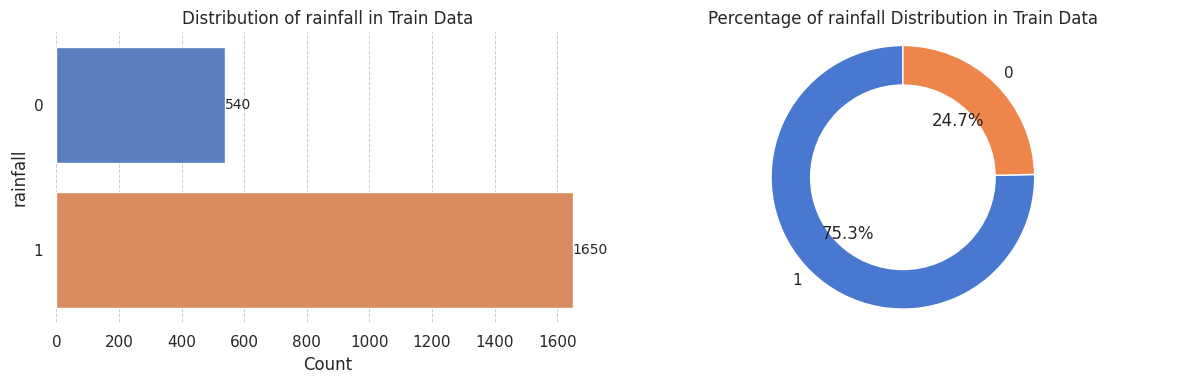

In [12]:
def plot_target_distribution(data, target_variable, title_suffix=""):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(y=target_variable, data=data, ax=axes[0])
    axes[0].set_title(f'Distribution of {target_variable} in {title_suffix}')
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel(target_variable)

    for p in axes[0].patches:
        axes[0].annotate(f'{int(p.get_width())}', 
                         (p.get_width(), p.get_y() + p.get_height() / 2), 
                         ha='left', va='center', 
                         fontsize=10)

    axes[0].set_axisbelow(True)
    axes[0].grid(axis='x', linestyle='--', linewidth=0.7)  
    sns.despine(left=True, bottom=True)

    rainfall_counts = data[target_variable].value_counts()
    wedges, texts, autotexts = axes[1].pie(
        rainfall_counts, 
        labels=rainfall_counts.index, 
        autopct='%1.1f%%', 
        startangle=90
    )
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)
    axes[1].set_title(f'Percentage of {target_variable} Distribution in {title_suffix}')
    axes[1].axis('equal')

    plt.tight_layout()
    plt.show()


plot_target_distribution(train_data, 'rainfall', title_suffix="Train Data")

## **Rainfall Distribution Analysis**

**Distribution of Rainfall in Train Data:**
- **Significant Imbalance:** There is an overrepresentation of instances of rainfall, approximately 75.3% of the data points indicating rainfall while only 24.7% indicate the absence of rain.
- **Implications for Model Training:** This imbalance could pose a challenge for model training, leading to bias towards the majority class.

## **Numerical Variable Distributions Across Datasets**

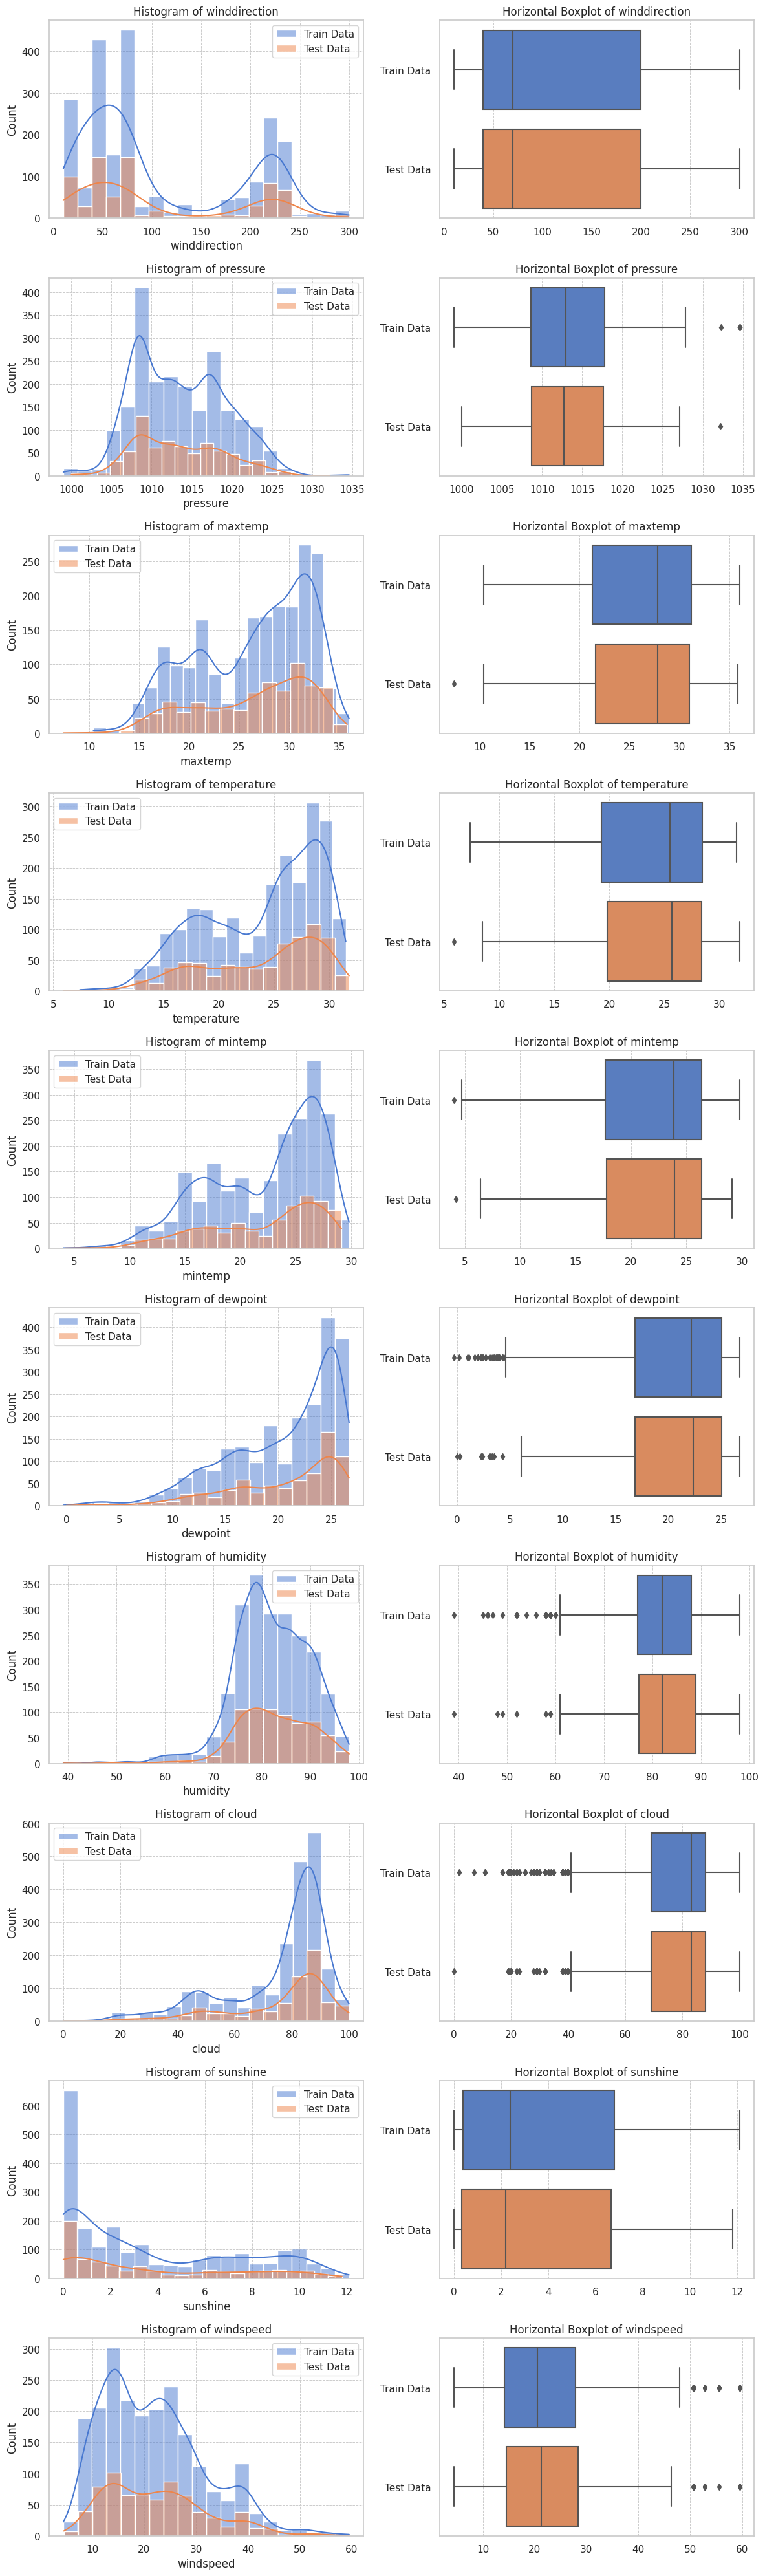

In [13]:
fig, axes = plt.subplots(len(numerical_variables), 2, figsize=(12, len(numerical_variables) * 4))

for i, feature in enumerate(numerical_variables):
    # Histogram
    sns.histplot(train_data[feature], label='Train Data', bins=20, kde=True, ax=axes[i, 0])
    sns.histplot(test_data[feature], label='Test Data', bins=20, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {feature}')
    axes[i, 0].legend()
    axes[i, 0].grid(linestyle='--', linewidth=0.7)

  # Horizontal Boxplot
    sns.boxplot(data=[train_data[feature], test_data[feature]], 
                orient='h', ax=axes[i, 1])
    axes[i, 1].set_title(f'Horizontal Boxplot of {feature}')
    axes[i, 1].set_yticklabels(['Train Data', 'Test Data'])
    axes[i, 1].grid(axis='x', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

## **Numerical Variable Distributions Across Datasets**

**Day:**
- Train and test data show a relatively uniform distribution. As does the original dataset over a limitted range.  
- Train and test data likely cover multiple years.

**Pressure:**
- All datasets show a relatively normal distribution centered around a similar mean.
- Outliers are present in all three data sets.  
- Atmospheric pressure is relatively stable across all datasets.
- Their are outliers.

**Maxtemp, Temperature, Mintemp:**
- These temperature-related features have similar distributions, with a relatively normal shape.  
- Temperatures are generally consistent across datasets.

**Dewpoint:**
- The dewpoint distributions are similar across datasets, indicating consistent moisture levels.
- Slight negative skew is present in all the datasets.  
- Moisture patterns are relatively stable.
- Lower dewpoints are less common.

**Humidity:**
- Humidity levels show consistent distributions, with a slight left skew, indicating a trend towards higher humidity.  
- The climate is generally humid.  

**Cloud:**
- Cloud cover shows a bimodal distribution, with peaks at high cloud cover and a secondary peak at lower cloud cover.  
- The climate experiences both clear and overcast conditions.

**Sunshine:**
- Sunshine hours are heavily skewed towards lower values.
- Cloudy conditions are prevalent.

**Winddirection:**
- Wind direction shows a relatively uniform distribution, indicating variability in wind patterns.
- There are a few outliers.  
- Wind patterns are diverse.

**Windspeed:**  
- Wind speed is skewed towards lower values, with a long tail indicating occasional high wind speeds.
- There are a few outliers.  
- Moderate wind speeds are more common, but strong winds occur.

## **Correlation Analysis of Numerical Variables**

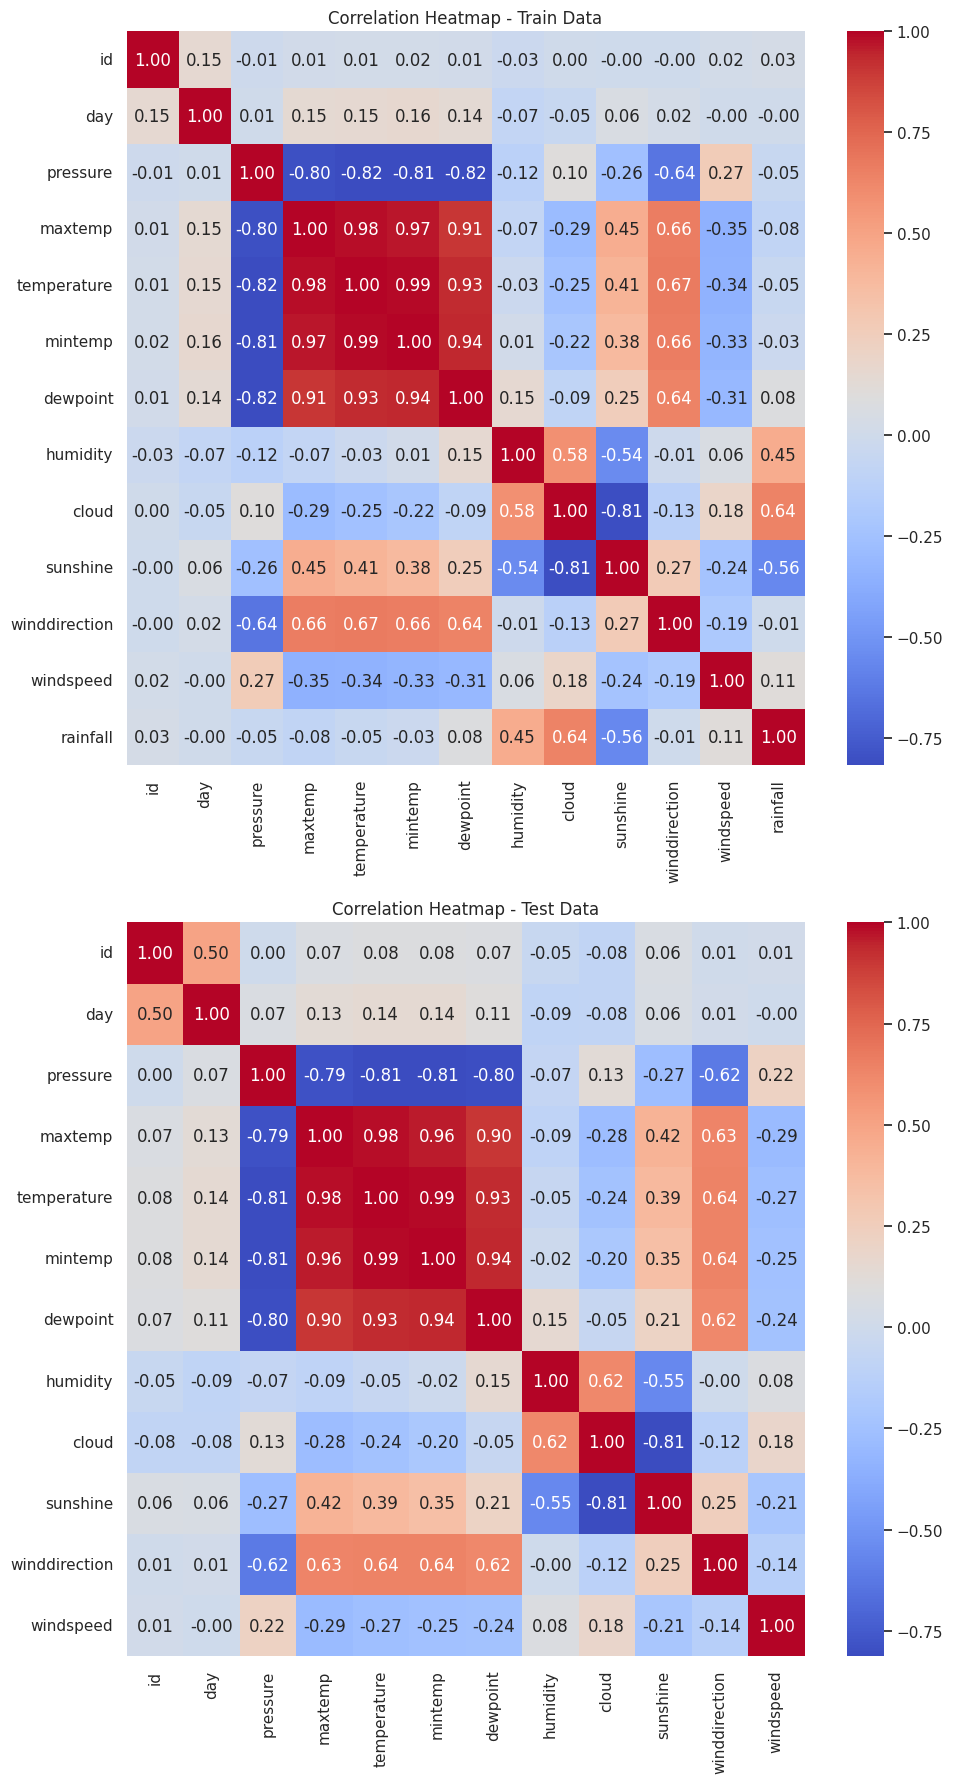

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(10, 18))  
# Train Data Heatmap
sns.heatmap(train_data.corr(), cmap='coolwarm', annot=True, fmt='.2f', ax=axes[0])
axes[0].set_title('Correlation Heatmap - Train Data')

# Test Data Heatmap
sns.heatmap(test_data.corr(), cmap='coolwarm', annot=True, fmt='.2f', ax=axes[1])
axes[1].set_title('Correlation Heatmap - Test Data')

plt.tight_layout()
plt.show()

## **Correlation Analysis of Numerical Variables**

**General Observations Across All Datasets:**  

**Temperature Correlations:**
- maxtemp, temperature, and mintemp exhibit very strong positive correlations across all datasets. This indicates that these temperature-related features move together consistently and possible redudency between these numerical features.
- They show strong negative correlations with pressure.
- They show a strong positive correlation with dewpoint.

**Pressure Correlations:**
- pressure has strong negative correlations with all temperature-related features and dewpoint across all datasets.
- pressure has a moderate positive correlation with windspeed.

**Humidity Correlations:**
- humidity shows a moderate positive correlation with cloud and a moderate negative correlation with sunshine across all datasets.
- humidity has a moderate positive correlation with rainfall.

**Cloud and Sunshine Correlations:**
- cloud and sunshine have a strong negative correlation, indicating that cloudy conditions are associated with less sunshine.
- cloud has a moderate positive correlation with rainfall.

**Wind Direction Correlations:**
- winddirection has a moderate negative correlation with pressure and a moderate positive correlation with the temperature related columns.

**Rainfall Correlations:**
- rainfall has a moderate positive correlation with humidity and cloud and a moderate negative correlation with sunshine.

**Intresting Thoughts**
- The moderate correlation in winddirection and temperature could suggest that wind direction may be associated with warmer air masses?

## **KDE Plots for Target and Numerical Varible Relationship**

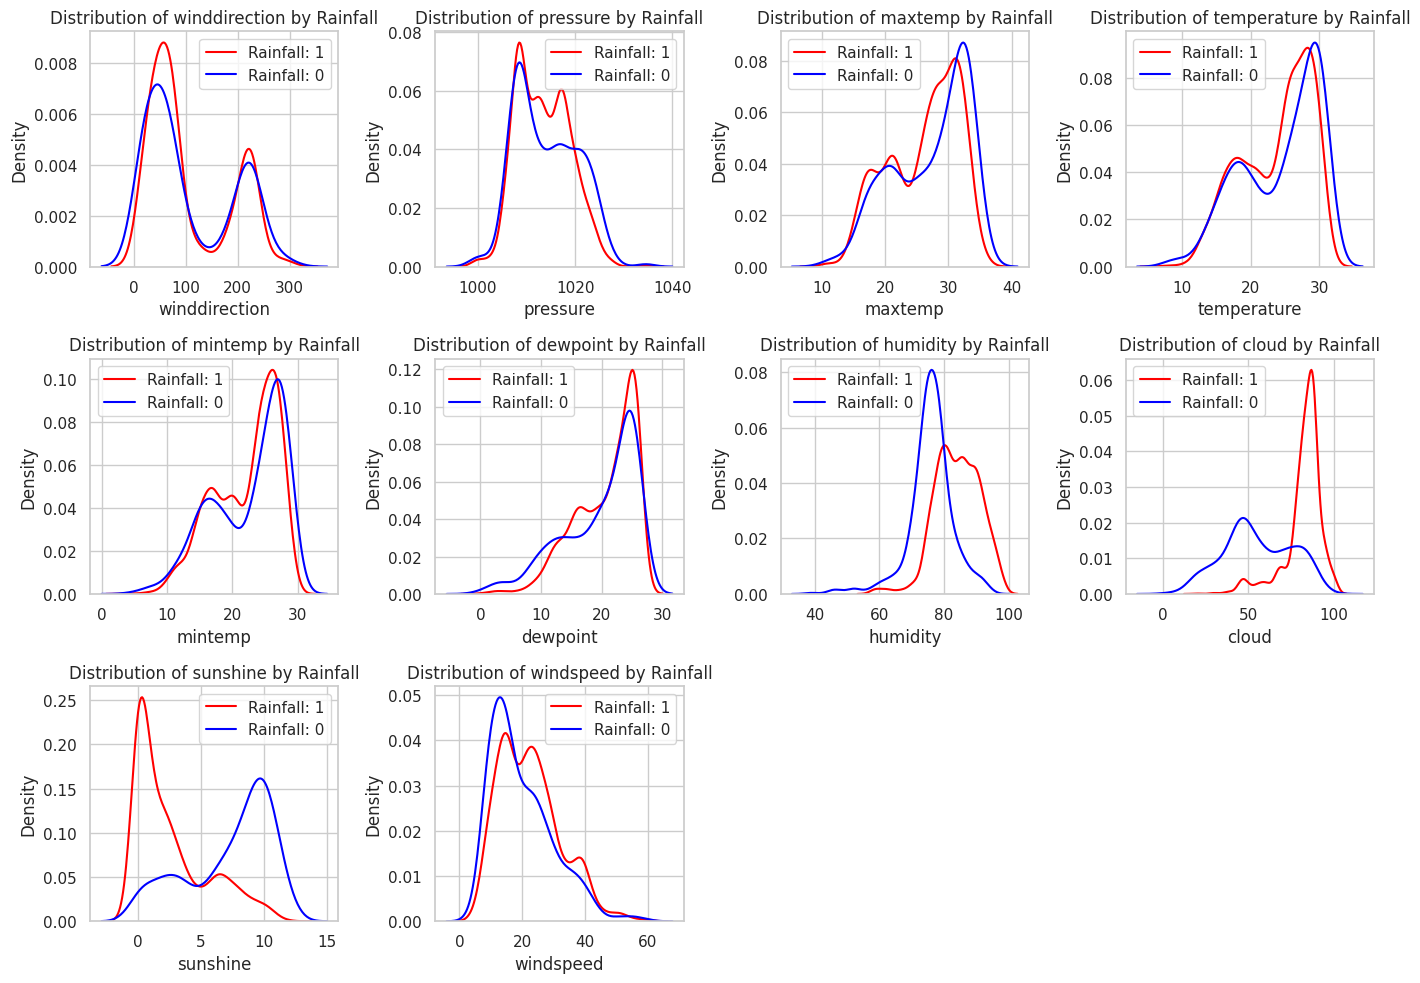

In [15]:
# KDE plot for Feature-Target Relationship
plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_variables, 1):
    plt.subplot(3, 4, i)
    sns.kdeplot(train_data[col][train_data['rainfall'] == 1], color='red', label='Rainfall: 1')
    sns.kdeplot(train_data[col][train_data['rainfall'] == 0], color='blue', label='Rainfall: 0')
    plt.title(f'Distribution of {col} by Rainfall')
    plt.legend()
plt.tight_layout()
plt.show()

## **Pair Plots for Numerical Variable Relationships**


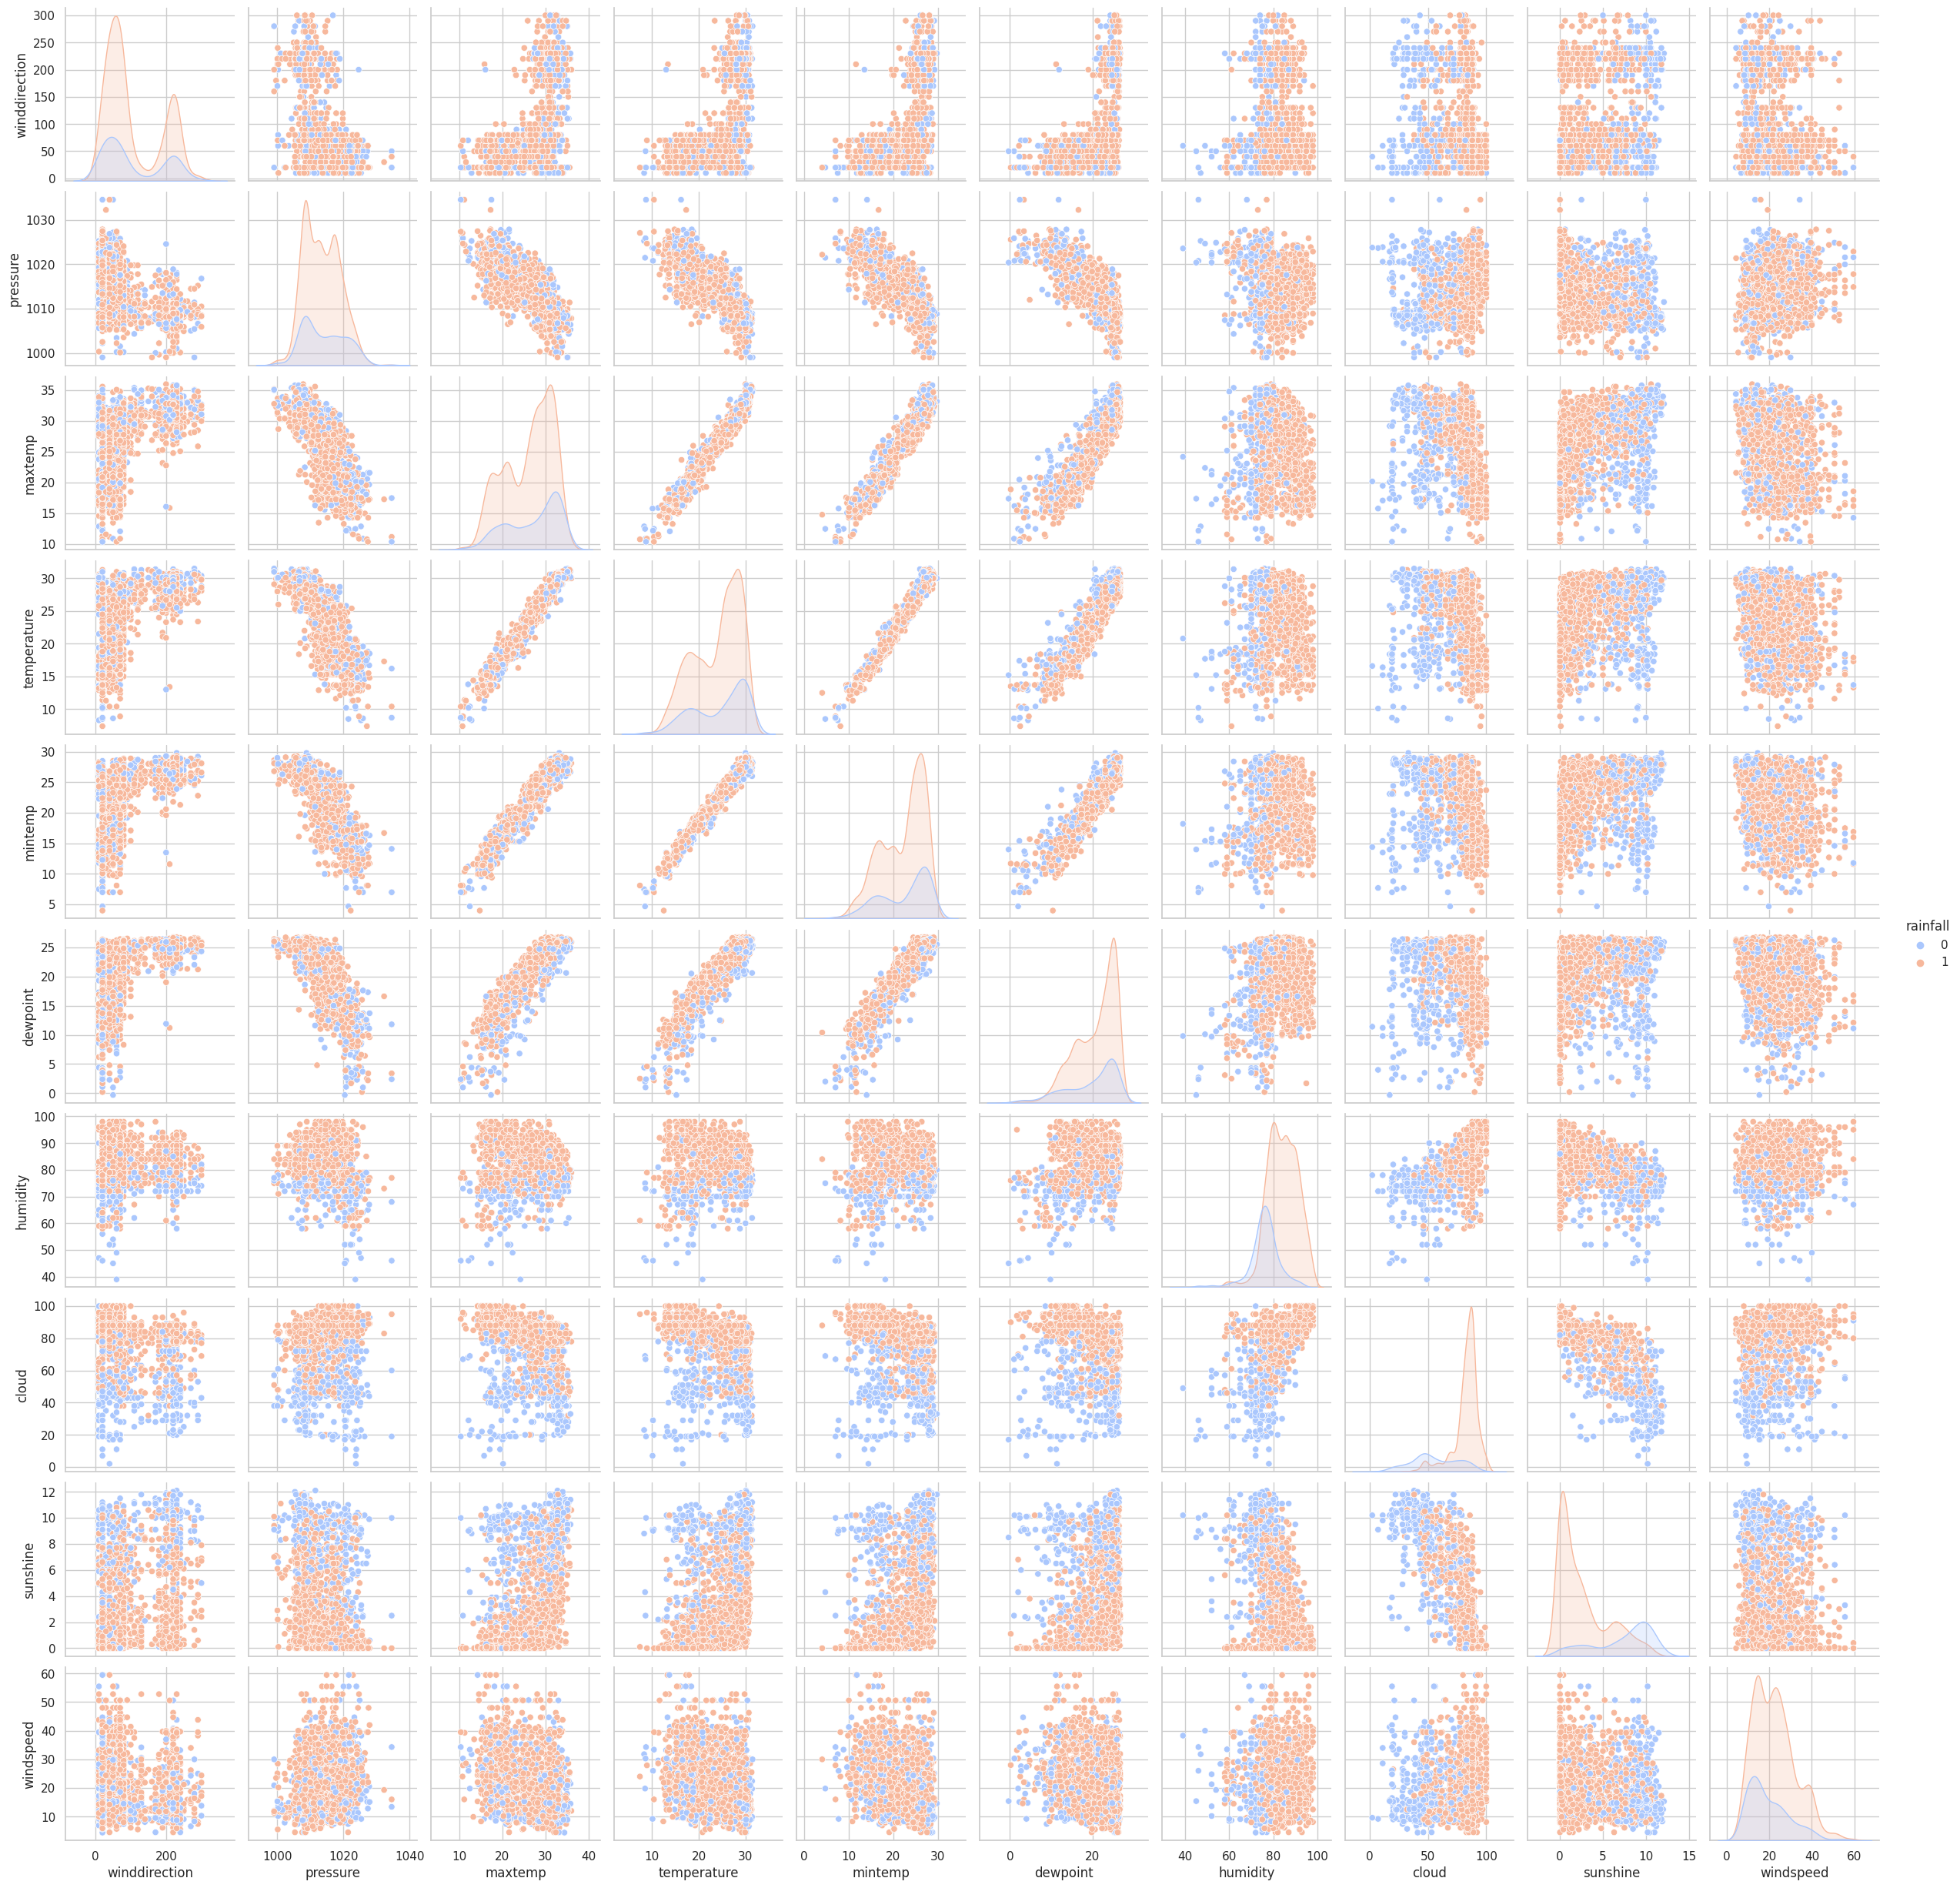

In [16]:
#Visualising relationships between variables
sns.pairplot(train_data[numerical_variables + ['rainfall']], hue='rainfall', palette='coolwarm', diag_kind='kde')
plt.show()

## **Feature Engineering**

In [17]:
def feature_engineering_data(data):
    # Feature Engineering
    data["dew_humidity"] = data["dewpoint"] * data["humidity"] # ***
    data["cloud_windspeed"] = data["cloud"] * data["windspeed"] # ***
    data["cloud_to_humidity"] = data["cloud"] / data["humidity"]
    data["temp_to_sunshine"] = data["sunshine"] / data["temperature"] # ***

    
    #data["temp_range"] = data["maxtemp"] - data["mintemp"]
    #data["temp_from_dewpoint"] = data["temparature"] - data["dewpoint"] # **?
    #data["wind_speeddirection"] = data["windspeed"] * data["winddirection"]
    #data['avg_temp'] = (data['maxtemp'] + data['mintemp']) / 2
    #data['cloud_persistence'] = data['cloud'] * data['sunshine']  # If both are low, it means the cloud cover persists.
    #data['pressure_temp_ratio'] = data['pressure'] / (data['temparature'] + 1)  # Avoid division by zero.
    #data['dew_temp_diff'] = data['temparature'] - data['dewpoint']
    #data['dew_humidity_ratio'] = data['dewpoint'] / (data['humidity'] + 1)
    #data['cloud_humidity_plus'] = data['cloud'] + data["humidity"] 
    #data['cloud_humidity_sunshine_plus'] = data['cloud'] + data["humidity"] + data['sunshine']
    #data['cloud_sunshine_*'] = data['cloud'] * data['sunshine']
    data['wind_temp_interaction'] = data['windspeed'] * data['temperature']
    #data['sunshine_wind_interaction'] = data['sunshine'] + data['windspeed'] # *
    #data['cloud_humidity_ratio'] = data['cloud'] + (data['humidity'])  # Avoid division by zero
    #data['pressure_temp_ratio'] = data['pressure'] / (data['temparature'] + 1)  # Avoid division by zero
    #data['cloud_wind_ratio'] = data['cloud'] / (data['windspeed'] + 1)  # Avoid division by zero


    #data['cloud_coverage_rate'] = data['cloud'] / 100  # Normalize to 0-1 range 
    #data['cloud_sun_interaction'] = data['cloud'] * (1 - data['sunshine'])

    
    #data['weather_severity'] = (data['cloud'] * data['humidity']) / (data['pressure'] * (data['sunshine'] + 1))
    data['cloud_sun_ratio'] = data['cloud'] / (data['sunshine'] + 1) # ***
    #data["cloud_sunshine_+"] = data["cloud"] + data["sunshine"]
    #data["cloud_sunshine_-"] = data["cloud"] - data["sunshine"]
    data["dew_humidity/sun"] = data["dewpoint"] * data["humidity"] / (data['sunshine'] + 1)
    data["dew_humidity_+"] = data["dewpoint"] * data["humidity"]
    

    data['humidity_sunshine_*'] = data["humidity"] * data['sunshine']

    data["cloud_humidity/pressure"] = (data["cloud"] * data["humidity"]) / data["pressure"]
    

    # Extract temporal features
    data['month'] = ((data['day'] - 1) // 30 + 1).clip(upper=12)
    data['season'] = data['month'].apply(lambda x: 1 if 3 <= x <= 5  # Spring
                                         else 2 if 6 <= x <= 8  # Summer
                                         else 3 if 9 <= x <= 11  # Autumn
                                         else 0)  # Winter
    # Seasonal trends
    #data['season_temp_trend'] = data['temparature'] * data['season']
    data['season_cloud_trend'] = data['cloud'] * data['season']
    

    # Seasonal deviation from mean values
    data['season_cloud_deviation'] = data['cloud'] - data.groupby('season')['cloud'].transform('mean')
    data['season_temperature'] = data['temperature'] * data['season']  # Interaction of temper



    
    data = data.drop(columns=["month"])
    #data['season_temp_trend'] = data['avg_temp'] * data['season']
    #data['season_dewpoint_trend'] = data['dewpoint'] * data['season']
    #data["dew_humidity_with_season"] = data['humidity'] * data['season']
    
    data = data.drop(columns=["maxtemp", "winddirection","humidity","temperature","pressure","day","season"])

    return data

# Apply to train and test datasets
train_data = feature_engineering_data(train_data)
test_data = feature_engineering_data(test_data)

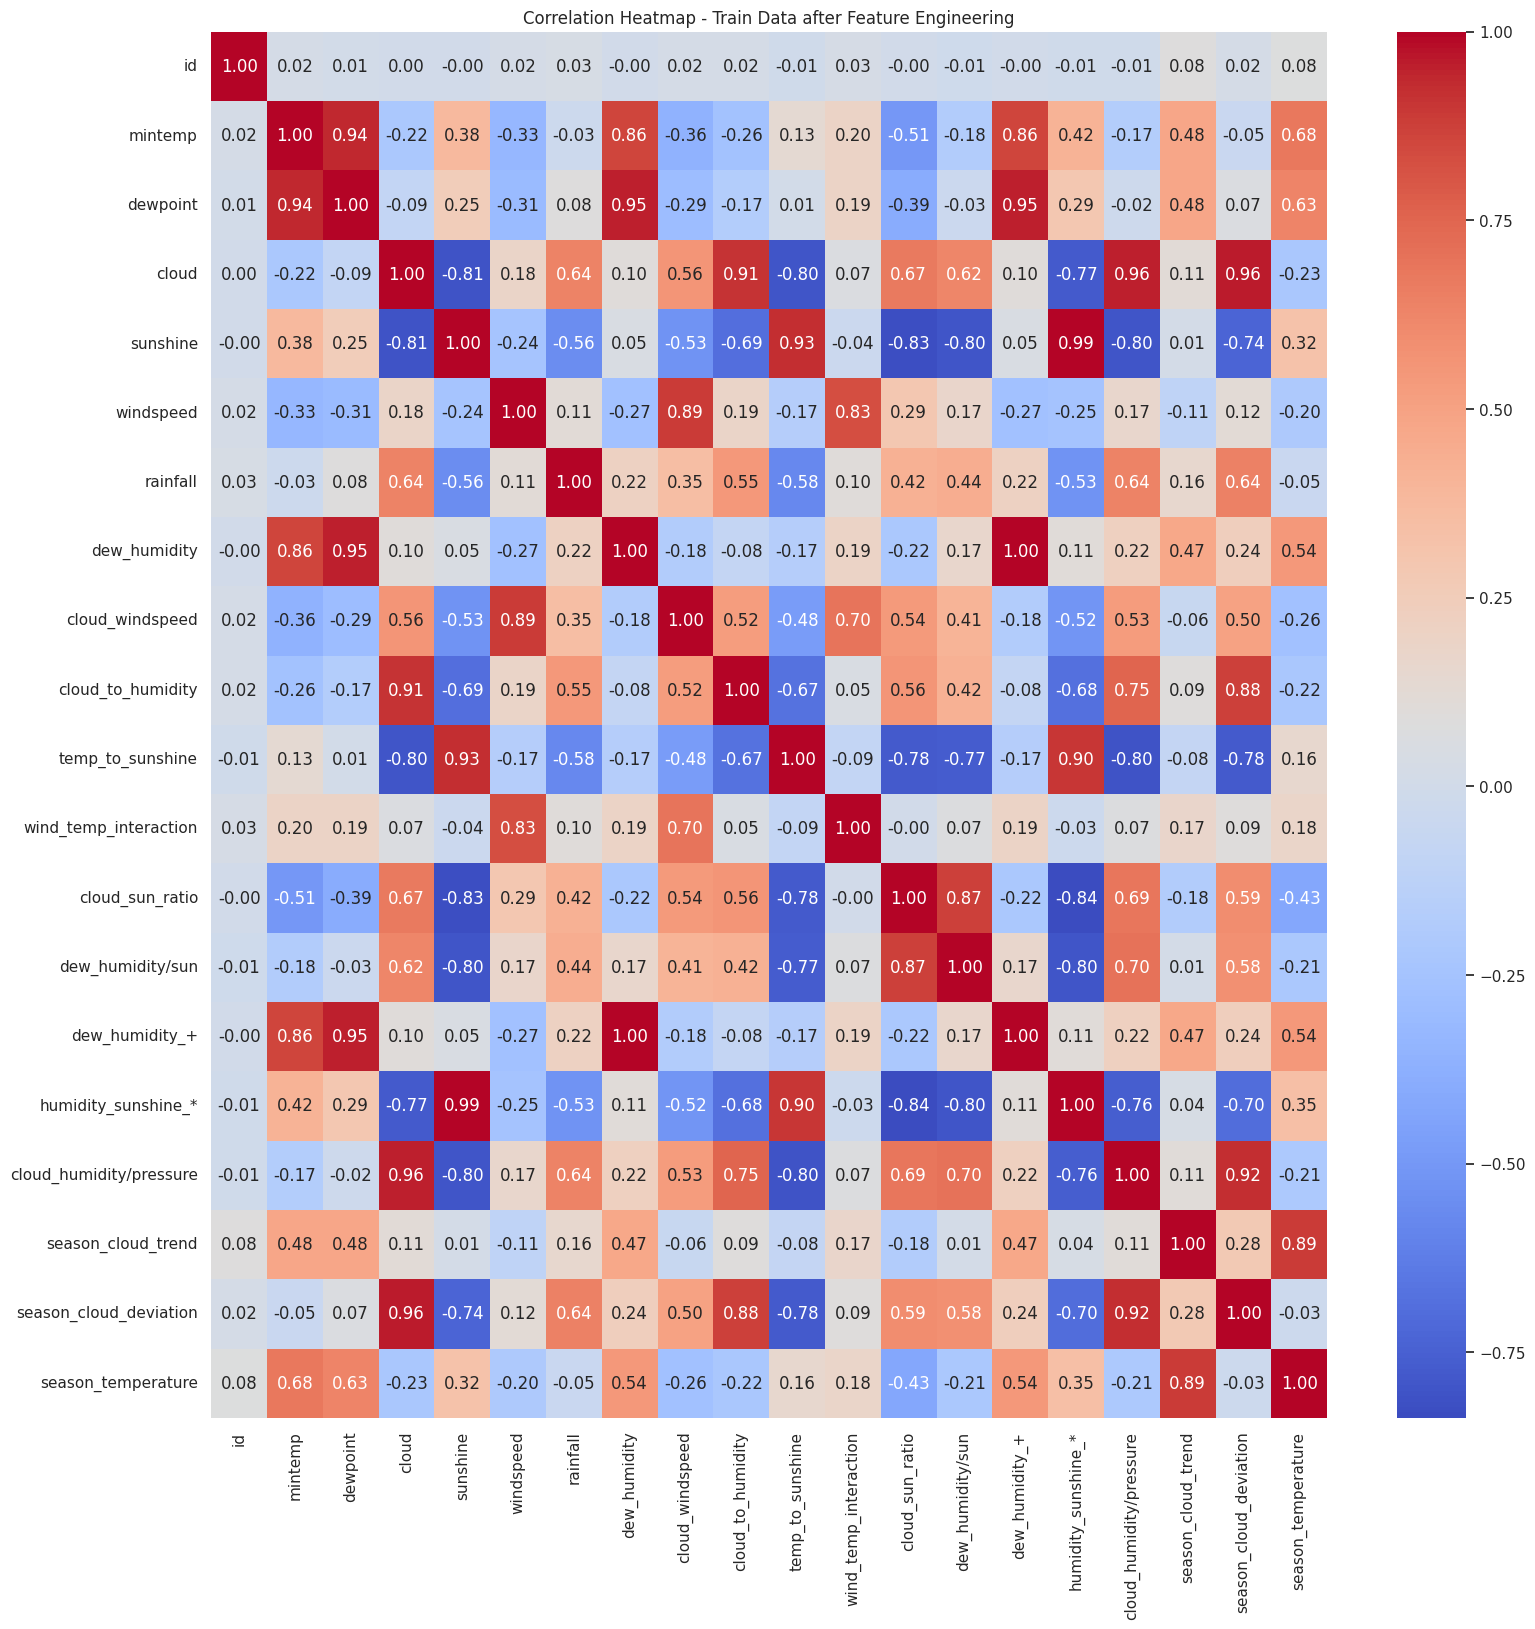

In [35]:
# Train Data Heatmap - Feature Engineering
plt.figure(figsize=(18, 18))
corr_matrix = train_data.corr()
sns.heatmap(train_data.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Heatmap - Train Data after Feature Engineering')

plt.show()

## **Model and Feature Analysis**

In [19]:
# Select features and target variable
X = train_data.drop(['rainfall', 'id'], axis=1)
y = train_data['rainfall']
X_test = test_data.drop(['id'], axis=1)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [20]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42,max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(random_state=42, max_iter=100, hidden_layer_sizes=(10)),
    "XGBoost": XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.05, max_depth=6),
    "CatBoost": CatBoostClassifier(random_state=42, iterations=100, learning_rate=0.14, depth=6, verbose=0)
}

# Train models using StratifiedKFold CV
FOLDS = 13
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
auc_scores = {}
roc_curves = {}

for name, model in models.items():
    oof_preds = np.zeros(len(y))
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        
        if hasattr(model, 'fit'):
            if "eval_set" in model.fit.__code__.co_varnames:
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=0)
            else:
                model.fit(X_train, y_train)
        
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y, oof_preds)
    auc_scores[name] = auc_score
    fpr, tpr, _ = roc_curve(y, oof_preds)
    roc_curves[name] = (fpr, tpr, auc_score)
    print(f"{name}: AUC = {auc_score:.4f}")

Logistic Regression: AUC = 0.8938
Random Forest: AUC = 0.8794
Gradient Boosting: AUC = 0.8897
Support Vector Machine: AUC = 0.8504
K-Nearest Neighbors: AUC = 0.8537
Neural Network: AUC = 0.8923
XGBoost: AUC = 0.8865
CatBoost: AUC = 0.8985


## **ROC Curve Comparison**

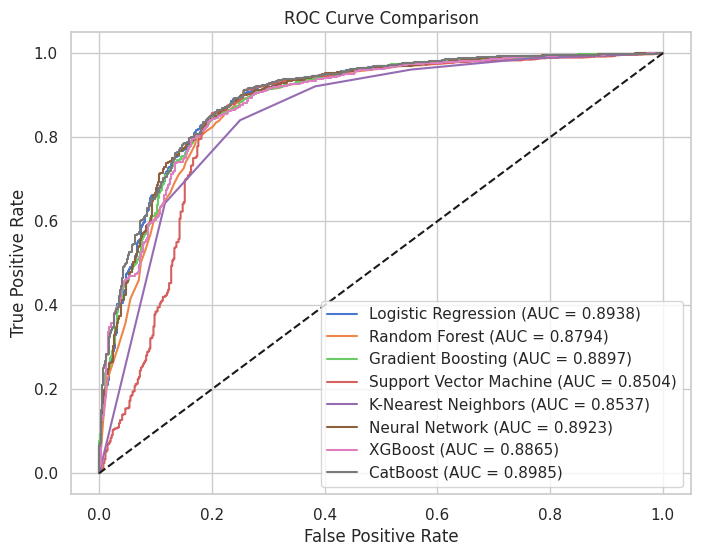

In [21]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr, auc_score) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [22]:
# Find the best model overall
best_model_name = max(auc_scores, key=auc_scores.get)
best_model = models[best_model_name]
print(f"Best Model Overall: {best_model_name} with AUC = {auc_scores[best_model_name]:.4f}")

Best Model Overall: CatBoost with AUC = 0.8985


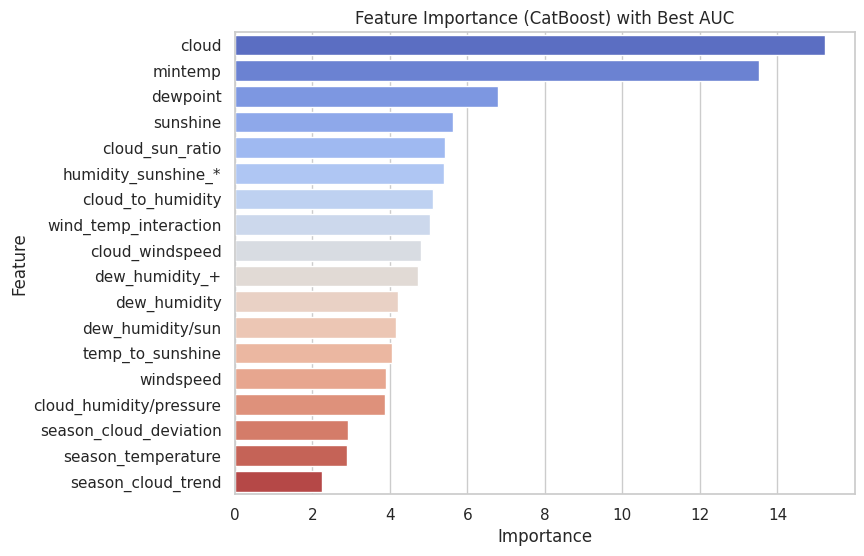

In [30]:
# Check if the model has feature_importances_ attribute
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    importance_type = 'Feature Importance'
else:
    # For logistic regression, use coefficients as importance
    feature_importance = np.abs(best_model.coef_[0])
    importance_type = 'Coefficient Magnitudes'

# Create a DataFrame to combine feature names and their importance values
feature_df = pd.DataFrame({
    'Feature': train_data.drop(['rainfall', 'id'], axis=1).columns,
    'Importance': feature_importance
})

# Sort the features by importance in descending order
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette="coolwarm")
plt.title(f"{importance_type} ({best_model_name}) with Best AUC")
plt.show()

In [24]:
# Select the best model based on AUC
best_model_name = max(auc_scores, key=auc_scores.get)
best_model = models[best_model_name]

# Check if the model has feature_importances_ attribute
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    importance_type = 'Feature Importance'
else:
    # For logistic regression, use coefficients as importance
    feature_importance = np.abs(best_model.coef_[0])
    importance_type = 'Coefficient Magnitudes'

# Create a DataFrame to combine feature names and their importance values
feature_df = pd.DataFrame({
    'Feature': train_data.drop(['rainfall', 'id'], axis=1).columns,
    'Importance': feature_importance
})

# Sort the features by importance in descending order
feature_df = feature_df.sort_values(by='Importance', ascending=False)

In [25]:
# List of top N features to try 
top_feature_counts = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

# Variables to track the best AUC and corresponding top features
best_auc_top = 0
best_top_n = 0
best_oof_preds_top = None

# Loop over different top feature counts
for top_n in top_feature_counts:
    # Select the top N features
    top_features = feature_df.head(top_n)['Feature']
    
    # Prepare the data with the selected top N features
    X_top = X[:, [train_data.drop(['rainfall', 'id'], axis=1).columns.get_loc(col) for col in top_features]]
    X_test_top = X_test[:, [train_data.drop(['rainfall', 'id'], axis=1).columns.get_loc(col) for col in top_features]]

    # Retrain the best model using the top N features
    best_model.fit(X_top, y)

    # Make predictions and calculate AUC for the top N features
    oof_preds_top = np.zeros(len(y))
    for train_idx, val_idx in skf.split(X_top, y):
        X_train, X_val = X_top[train_idx], X_top[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        best_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
        oof_preds_top[val_idx] = best_model.predict_proba(X_val)[:, 1]

    # Calculate and print AUC score for top N features model
    auc_score_top = roc_auc_score(y, oof_preds_top)
    print(f"AUC for top {top_n} features model: {auc_score_top:.4f}")
    
    # Track the best AUC and corresponding features
    if auc_score_top > best_auc_top:
        best_auc_top = auc_score_top
        best_top_n = top_n
        best_oof_preds_top = oof_preds_top

# Now plot the feature importance for the set with the highest AUC
best_features = feature_df.head(best_top_n)

AUC for top 8 features model: 0.8958
AUC for top 9 features model: 0.8971
AUC for top 10 features model: 0.8984
AUC for top 11 features model: 0.8996
AUC for top 12 features model: 0.8965
AUC for top 13 features model: 0.8974
AUC for top 14 features model: 0.8982
AUC for top 15 features model: 0.9008
AUC for top 16 features model: 0.9000
AUC for top 17 features model: 0.8977
AUC for top 18 features model: 0.8982


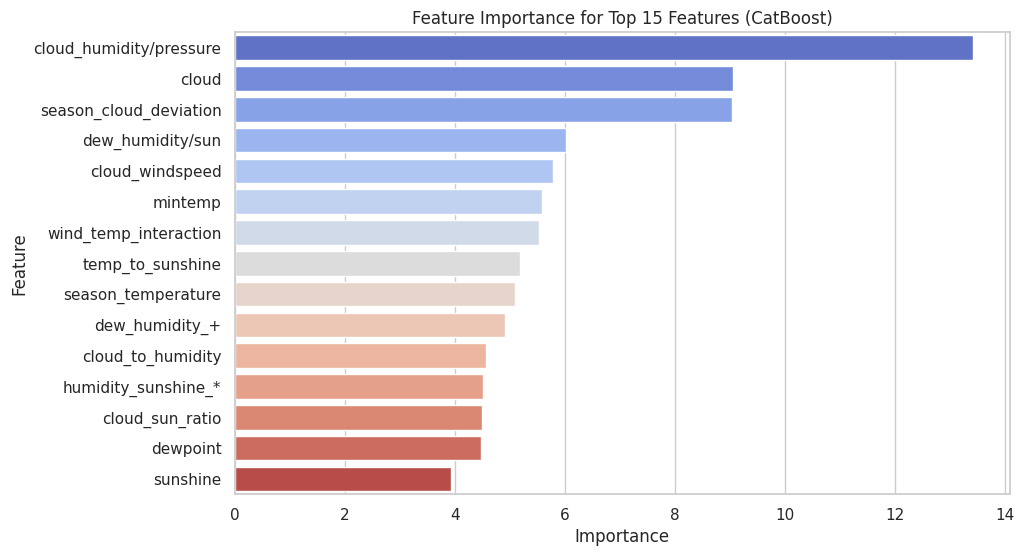

Best Model: CatBoost
Best AUC: 0.9008 using Top 15 Features


In [29]:
# Plotting the feature importance for the best model with the highest AUC
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=best_features, palette="coolwarm")
plt.title(f"{importance_type} for Top {best_top_n} Features ({best_model_name})")
plt.show()

print(f"Best Model: {best_model_name}")
print(f"Best AUC: {best_auc_top:.4f} using Top {best_top_n} Features")

## **Submission File**

In [27]:
# Predictions for the test set with the top N features
test_preds = best_model.predict_proba(X_test_top)[:, 1]

# Submission
submission = pd.DataFrame({'id': test_data['id'], 'rainfall': test_preds})
submission.to_csv("submission.csv", index=False)
print("\nSubmission file saved as 'submission.csv'.")


Submission file saved as 'submission.csv'.


In [28]:
submission

id  rainfall
0    2190  0.967196
1    2191  0.977204
2    2192  0.939921
3    2193  0.136824
4    2194  0.065418
..    ...       ...
725  2915  0.973129
726  2916  0.811719
727  2917  0.971440
728  2918  0.977742
729  2919  0.938505

[730 rows x 2 columns]